<a href="https://colab.research.google.com/github/ab17254/ce888/blob/main/Assignment/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install 'aif360[all]'

     |████████████████████████████████| 21.2MB 31.3MB/s 
     |████████████████████████████████| 2.6MB 29.5MB/s 
     |████████████████████████████████| 972kB 44.5MB/s 
     |████████████████████████████████| 276kB 46.2MB/s 
     |████████████████████████████████| 9.2MB 43.5MB/s 
     |████████████████████████████████| 3.4MB 41.3MB/s 
     |████████████████████████████████| 21.6MB 1.9MB/s 
     |████████████████████████████████| 235kB 41.2MB/s 
     |████████████████████████████████| 25.3MB 1.5MB/s 
     |████████████████████████████████| 747kB 44.9MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394769 sha256=d921f6f41db9409566ce56b594a0dd6e66d9f7607278c22952dcd4d1d941af28
  Stored in directory: /root/.cache/pip/wheels/66/82/7b/ac2a79b8caf97e15ed415162a7f272cbba1e2e2c851fa76ae3
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=6d0331827ff0b8f4828f0e1955d9aca4b7b33f666a30b8a2f38783c32975f0fd
  Sto

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr
from aif360.sklearn.metrics import generalized_fnr, difference

In [5]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: content/data/
  inflating: content/data/arrest_manchester.csv  
  inflating: content/data/data_all.csv  
  inflating: content/data/arrest_london.csv  
  inflating: content/data/arrest_essex.csv  
  inflating: content/data/arrest_wiltshire.csv  
  inflating: content/data/arrest_lancashire.csv  
  inflating: content/data/arrest_suffolk.csv  
  inflating: content/data/arrest_all.csv  


In [6]:
df = pd.read_csv('/content/content/data/data_all.csv')
df

,Unnamed: 0,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,0,2006/07,31.376667,17.333333,60.00,31.8,24.0,23.75,2111,1350,1419,632,134372
1,1,2007/08,33.060000,19.000000,62.75,31.8,26.0,25.75,2231,1371,1525,656,134000
2,2,2008/09,33.770000,20.000000,65.00,31.6,25.5,26.75,2472,1427,1699,689,135651
3,3,2009/10,33.503333,19.666667,65.25,31.6,24.5,26.50,2607,1446,1844,745,135293
4,4,2010/11,33.706667,19.833333,66.75,32.2,24.0,25.75,2582,1442,1838,754,130870
5,5,2011/12,30.876667,17.833333,61.00,29.8,22.0,23.75,2607,1420,1871,766,125579
6,6,2012/13,27.226667,15.833333,52.75,25.8,20.0,21.75,2563,1361,1865,749,121086
7,7,2013/14,26.436667,15.833333,51.75,24.6,19.0,21.00,2665,1352,1922,776,119071
8,8,2014/15,24.833333,14.666667,49.75,23.0,18.0,18.75,2795,1373,2028,785,117757
9,9,2015/16,23.770000,14.000000,48.50,21.6,18.0,16.75,2881,1433,2096,808,114437


In [7]:
data=df.values.T[8]

In [8]:
data

array([2111, 2231, 2472, 2607, 2582, 2607, 2563, 2665, 2795, 2881, 3104,
       3266], dtype=object)

In [10]:
def bootstrap_mean_ci(sample, sample_size, n_bootstraps, ci):
  samples = np.zeros((n_bootstraps, sample_size))
  for i in range(n_bootstraps):
    samples[i] = np.random.choice(sample, sample_size, replace=True)
  data_mean = np.mean(samples)
  n_mean = np.mean(samples, axis=1)
  lower, upper = np.percentile(n_mean, [((100-ci)/2), (100 - (100-ci)/2)])
  return data_mean, lower, upper

In [11]:
mean, lower, upper = bootstrap_mean_ci(data, data.shape[0], 100000, 80)
print('''
  Mean: {}
  Lower Mean (95% CI): {}8
  Upper Mean (95% CI): {}
'''.format(mean, lower, upper))


  Mean: 2657.498830833333
  Lower Mean (95% CI): 2542.258
  Upper Mean (95% CI): 2773.8333333333335



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100000.0)

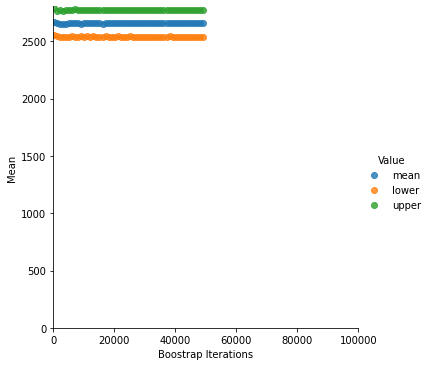

In [12]:
boots = []
for i in range(100, 50000, 1000):
    boot = bootstrap_mean_ci(data, data.shape[0], i, 80)
    boots.append([i, boot[0], "mean"])
    boots.append([i, boot[1], "lower"])
    boots.append([i, boot[2], "upper"])

df_boot = pd.DataFrame(boots, columns=['Boostrap Iterations', 'Mean', "Value"])
sns_plot = sns.lmplot(df_boot.columns[0], df_boot.columns[1], data=df_boot, fit_reg=False, hue="Value")

sns_plot.axes[0, 0].set_ylim(0,)
sns_plot.axes[0, 0].set_xlim(0, 100000)

In [13]:
df.describe()

,Unnamed: 0,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5.500000,28.271111,16.472222,55.645833,26.800000,20.916667,21.520833,2657.000000,1402.583333,1883.416667,754.416667,124381.250000
std,3.605551,5.138060,2.970251,8.951548,5.281873,3.970535,4.739172,326.587313,37.553497,256.182271,67.752837,9342.720337
min,0.000000,19.413333,11.166667,40.500000,18.400000,14.000000,13.000000,2111.000000,1350.000000,1419.000000,632.000000,111506.000000
25%,2.750000,24.567500,14.500000,49.437500,22.650000,18.000000,18.250000,2540.250000,1368.500000,1803.250000,731.000000,116927.000000
50%,5.500000,29.051667,16.583333,56.375000,27.800000,21.000000,22.750000,2607.000000,1422.000000,1868.000000,760.000000,123332.500000
75%,8.250000,33.170833,19.166667,63.312500,31.650000,24.125000,25.750000,2816.500000,1432.250000,2045.000000,790.750000,134093.000000
max,11.000000,33.770000,20.000000,66.750000,32.200000,26.000000,26.750000,3266.000000,1446.000000,2309.000000,852.000000,135651.000000


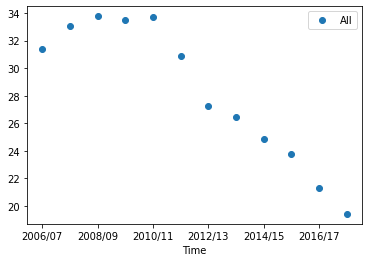

In [14]:
df.plot(x='Time',y='All', style='o')
plt.show()

In [15]:
df['Time'] = df['Time'].str[:-3]

In [17]:
df

,Unnamed: 0,Time,All,Asian,Black,Mixed,Other,White,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,0,2006,31.376667,17.333333,60.00,31.8,24.0,23.75,2111,1350,1419,632,134372
1,1,2007,33.060000,19.000000,62.75,31.8,26.0,25.75,2231,1371,1525,656,134000
2,2,2008,33.770000,20.000000,65.00,31.6,25.5,26.75,2472,1427,1699,689,135651
3,3,2009,33.503333,19.666667,65.25,31.6,24.5,26.50,2607,1446,1844,745,135293
4,4,2010,33.706667,19.833333,66.75,32.2,24.0,25.75,2582,1442,1838,754,130870
5,5,2011,30.876667,17.833333,61.00,29.8,22.0,23.75,2607,1420,1871,766,125579
6,6,2012,27.226667,15.833333,52.75,25.8,20.0,21.75,2563,1361,1865,749,121086
7,7,2013,26.436667,15.833333,51.75,24.6,19.0,21.00,2665,1352,1922,776,119071
8,8,2014,24.833333,14.666667,49.75,23.0,18.0,18.75,2795,1373,2028,785,117757
9,9,2015,23.770000,14.000000,48.50,21.6,18.0,16.75,2881,1433,2096,808,114437


In [18]:
df.iloc[:, 8:]

,Asian Officers,Black Officers,Mixed Officers,Other Officers,White Officers
0,2111,1350,1419,632,134372
1,2231,1371,1525,656,134000
2,2472,1427,1699,689,135651
3,2607,1446,1844,745,135293
4,2582,1442,1838,754,130870
5,2607,1420,1871,766,125579
6,2563,1361,1865,749,121086
7,2665,1352,1922,776,119071
8,2795,1373,2028,785,117757
9,2881,1433,2096,808,114437


In [19]:
def linear_reg(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  regressor = LinearRegression()
  regressor.fit(X_train, y_train)
  print(regressor.intercept_)
  print(regressor.coef_)
  y_pred = regressor.predict(X_test)
  dataset = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
  print(dataset)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('Coefficient of Determination: %.2f'% metrics.r2_score(y_test, y_pred))

In [21]:
X = df.iloc[:, 8:].values
y = df.iloc[:, 3].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
X

In [22]:
linear_reg(X, y)

-32.82354192500084
[-0.0126025   0.00071118  0.01699353  0.00717777  0.00035702]
      Actual  Predicted
0  15.833333  16.143554
1  11.166667  12.192971
2  19.833333  19.031874
Mean Absolute Error: 0.7126615694101398
Mean Squared Error: 0.5972916935209256
Root Mean Squared Error: 0.7728464876810437
Coefficient of Determination: 0.95


In [33]:
from aif360.sklearn.datasets import fetch_adult
X, y, sample_weight = fetch_adult()


In [34]:
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)
y = pd.Series(y.factorize(sort=True)[0], index=y.index)


In [35]:
y

       race  sex
0      0     1      0
1      1     1      0
2      1     1      1
3      0     1      1
5      1     1      0
                   ..
48837  1     0      0
48838  1     1      1
48839  1     0      0
48840  1     1      0
48841  1     0      1
Length: 45222, dtype: int64